# Epoxy-resin polymer thermoset material

Run this notebook to reproduce the Deep Active Subspace (DAS) results for the epoxy resin application. Small variation in the results will occur due to the stochastic nature of the training procedure. Some KAS-GP are also displayed. These are loaded from file, and not directly computed here.

### Reference

Wouter Edeling, Maxime Vassaux, Yiming Yang, Shunzhou Wan, Peter Coveney, *Global ranking of the sensitivity of interaction potential contributions within classical molecular dynamics force fields*, (submitted), 2023.

### Install EasySurrogate

The Deep Active Subspace method is implemented in EasySurrogate. Uncomment to install.

In [29]:
#!pip install easysurrogate==0.24.1

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import easysurrogate as es
from scipy import linalg, stats
import pandas as pd
import json
import os
import seaborn as sns
from tqdm import tqdm

Several subroutines specific to this article are located in `../utils/utils.py`. Import this module.

In [31]:
import sys
sys.path.insert(1, '../')
from utils.utils import plot_sensitivity, plot_errors, plot_dist, early_stopping

In [32]:
%matplotlib inline
# save figures at 300 dpi
plt.rcParams['savefig.dpi'] = 300

### Load prior ranges

The JSON file below contains all default values and boundaries used for specifying the Uniform input parameter distributions. 

In [33]:
# Load the EasyVVUQ params dict
priors = json.load(open('./epoxy.params.json', 'r'))

### Load input parameter values

Load the Monte Carlo values of the inputs.

In [34]:
# input parameters
params = pd.read_csv('./data_epoxy/epoxy_inputs.csv')
param_names = params.keys()
params = params.values

# number of samples
n_samples = params.shape[0]

# number of inputs
D = params.shape[1]

# scale inputs within [-1, 1]
p_max = np.array([priors[name]['default'] * 1.15 for name in param_names])
p_min = np.array([priors[name]['default'] * 0.85 for name in param_names])
params = (params - 0.5 * (p_min + p_max)) / (0.5 * (p_max - p_min))

### Load output samples

Load the corresponding Monte Carlo outputs. We used `E11`, the 11 component of the elasticity tensor (equal to the Young's modulus `E` in this isotropic case), and the Poisson ratio.

In [35]:
# Output QoI
QoI = 'E11'   # E11=E22_E33=E due to isotropy of the material
# QoI = 'poisson'

output = pd.read_csv('./data_epoxy/epoxy_%s_output.csv' % (QoI,)).values

### Average over the random seeds (or not)

Each parameter value was replicated several times, changing only the random seed of the initial condition.

In [36]:
average_over_replicas = False

if not average_over_replicas:
    samples = output[:, 0].reshape([-1, 1])
else:
    samples = np.mean(output, axis=1, keepdims=True)

### Select $d$

This is the dimension of the active subspace.

In [37]:
d = 1

###  Set hyperparameters

In [38]:
# number of neurons per hidden layer 
n_hidden_neurons = 10
# number of hidden layer + output layer
n_layers = 3
# activation function
activation = 'tanh'

# mini batch size
batch_size = 32
# max number of epochs
n_epochs_max = 100
# number of mini-batch iterations per epoch
n_iter = int(n_samples / batch_size)

# early stopping parameters
min_delta = 0.001
patience = 3

### Train / test split

In [39]:
# test fraction
test_frac = 0.1
# indices of the test set
test_idx = int((1 - test_frac) * n_samples)
# training set
params_train = params[0:test_idx, :]
samples_train = samples[0:test_idx, :]
# test set
params_test = params[test_idx:, :]
samples_test = samples[test_idx:, :]

### Select how many replica neural networks to train

To compute confidence intervals on the results (due to the stochastic nature of the training), we train `n_rep` replica networks instead of relying a single network

In [40]:
n_rep = 20

### Train a deep active subspace network



In [41]:
# results dict
results_das = {}
# eigenvalues of gradient matrix C per epoch
results_das['eigvals'] = np.zeros([n_rep, D])
# global gradient-based sensitivity indices per epoch
results_das['V_i'] = np.zeros([n_rep, D])
# relative training and test error per epoch
results_das['errors'] = []
results_das['epoch_stop'] = np.zeros(n_rep, dtype=int)
results_das['projection_matrix'] = []
results_das['surrogate'] = []
results_das['C_das'] = []

In [42]:
def train_das(failure_criterion = 1.0):
    """
    Train DAS networks using early stopping.
    
    failure_criterion : float
        Most replica networks will converge, a small number might not. 
        failure_critertion is the value of the relative test error
        used to determine if a network did not converge. If exceeded
        the network will be discarded. Default value is 1.0 (100% test error).

    """
    min_test_error = 1.0

    # repeat analysis n_rep times to generate error bars on results
    for rep in range(n_rep):

        # train remaining epochs through early stopping
        final_test_error = 2.0
        while final_test_error > failure_criterion:
        
            # create new DAS network and train for 1 epoch
            das_surrogate = es.methods.DAS_Surrogate()
            das_surrogate.train(params_train, samples_train, d, 
                                n_iter=n_iter,
                                n_layers=n_layers,
                                n_neurons=n_hidden_neurons, 
                                activation=activation, 
                                batch_size=batch_size,
                                standardize_X=False, standardize_y=True)

            # train remaining epochs through early stopping
            errors, epoch = early_stopping(das_surrogate, n_iter,
                                           params_train, samples_train, 
                                           params_test, samples_test)
            final_test_error = errors[epoch, 1]

        results_das['errors'].append(errors)
        results_das['epoch_stop'][rep] = epoch

        ### Compute active subspace of the DAS network

        # the gradient matrix computed of the DAS network, computed using the classical AS method
        C_das = 0.0

        # Number of Monte Carlo samples
        n_mc = params.shape[0]    

        # Compute C_das, the gradient matrix of the DAS network
        das_samples = np.zeros(n_mc)
        for i, param in enumerate(params):
            # compute the derivative of f at the input layer (needed for C_das)
            df_dx = das_surrogate.derivative(param, norm=False)
            # update C_das
            C_das += np.dot(df_dx, df_dx.T) / n_mc

        results_das['C_das'].append(C_das)
            
        # solve eigenvalue problem for C_das
        eigvals_C_das, eigvecs_C_das = linalg.eigh(C_das)

        # Sort the eigensolutions in the descending order of eigenvalues
        order = eigvals_C_das.argsort()[::-1]
        eigvals_C_das = eigvals_C_das[order]
        eigvecs_C_das = eigvecs_C_das[:, order]

        # store eigenvalues of this iteration
        results_das['eigvals'][rep] = eigvals_C_das

        # the DAS weight matrix of the first hidden layer
#         W_1 = das_surrogate.neural_net.layers[1].W
#         results_das['projection_matrix'].append(W_1)
        # The dominant eigenvector(s) from the C_das matrix (alternative to W_1)
        results_das['projection_matrix'].append(eigvecs_C_das[:, 0:d])

        # perform sensitivity analysis using combined training and test data 
        das_analysis = es.analysis.DAS_analysis(das_surrogate)
        idx, V_i = das_analysis.sensitivity_measures(params, norm=False)
        results_das['V_i'][rep] = V_i.flatten() #* das_surrogate.neural_net.y_std ** 2

        # store surrogate
        results_das['surrogate'].append(das_surrogate)


Train `n_rep` DAS surrogate. A converged DAS network will have a test error well below 40%, set `failure_criterion=0.4`.

In [43]:
train_das(failure_criterion=0.4)

Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  450/450 samples to train the ML model
Neural net parameters
Number of layers = 3
Number of features = 103
Loss function = squared
Number of neurons per hidden layer = 10
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'linear']
This neural network has 134 weights.
Training Deep Active Subspace Neural Network...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 391.08it/s]


 loss = 1.2851
Relative training error = 44.6393 %
Relative test error = 38.3186 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 493.64it/s]


 loss = 0.6903
Relative training error = 42.8734 %
Relative test error = 38.8940 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6628


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 596.06it/s]


Relative training error = 39.9034 %
Relative test error = 37.2956 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 572.43it/s]


 loss = 0.3892
Relative training error = 36.5344 %
Relative test error = 37.0975 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 687.34it/s]


 loss = 0.4152
Relative training error = 32.9622 %
Relative test error = 35.1795 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 628.40it/s]

 loss = 0.4279


Relative training error = 29.3416 %
Relative test error = 33.3712 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 680.79it/s]

 loss = 0.4385


Relative training error = 26.5810 %
Relative test error = 30.8358 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 448.06it/s]

 loss = 0.4375


Relative training error = 23.8023 %
Relative test error = 28.7686 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 570.50it/s]

 loss = 0.3243
Relative training error = 21.5337 %


Relative test error = 26.2417 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1990


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 423.67it/s]


Relative training error = 19.8508 %
Relative test error = 23.6245 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 748.03it/s]

 loss = 0.3478


Relative training error = 18.4278 %
Relative test error = 22.7761 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 711.00it/s]


 loss = 0.2062
Relative training error = 17.3412 %
Relative test error = 21.6667 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 700.67it/s]

 loss = 0.3287


Relative training error = 16.2424 %
Relative test error = 21.3145 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 706.36it/s]

 loss = 0.1012
Relative training error = 15.4318 %


Relative test error = 20.6855 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 738.68it/s]


 loss = 0.3066
Relative training error = 14.6770 %
Relative test error = 19.6467 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 557.50it/s]

 loss = 0.1107


Relative training error = 14.1411 %
Relative test error = 18.6564 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 628.45it/s]

 loss = 0.0930


Relative training error = 13.7226 %
Relative test error = 17.5753 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.98it/s]

 loss = 0.0211


Relative training error = 13.4636 %
Relative test error = 16.6381 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 694.43it/s]


 loss = 0.0306
Relative training error = 13.0188 %
Relative test error = 16.7756 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 689.96it/s]


 loss = 0.1579
Relative training error = 12.6863 %
Relative test error = 16.2580 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 576.75it/s]

 loss = 0.0854


Relative training error = 12.4869 %
Relative test error = 15.4707 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 711.31it/s]

 loss = 0.0517


Relative training error = 12.1885 %
Relative test error = 14.5200 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 688.80it/s]

 loss = 0.1267
Relative training error = 11.9370 %


Relative test error = 14.3283 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 698.51it/s]

 loss = 0.0393
Relative training error = 11.6378 %
Relative test error = 15.1389 %



  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0370


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 661.08it/s]


Relative training error = 11.4143 %
Relative test error = 15.4256 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1483


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 627.90it/s]


Relative training error = 11.1910 %
Relative test error = 15.0655 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0553


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 659.21it/s]


Relative training error = 10.9640 %
Relative test error = 15.0881 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0729


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 737.46it/s]


Relative training error = 10.8077 %
Relative test error = 15.0638 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0389


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 680.70it/s]


Relative training error = 10.6308 %
Relative test error = 14.8171 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0410


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 698.72it/s]


Relative training error = 10.4887 %
Relative test error = 14.2656 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0385


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 784.28it/s]


Relative training error = 10.4091 %
Relative test error = 13.9305 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0308


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 754.51it/s]


Relative training error = 10.2996 %
Relative test error = 14.5797 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 574.69it/s]


 loss = 0.0400
Relative training error = 10.1397 %
Relative test error = 14.6159 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 737.84it/s]


 loss = 0.0607
Relative training error = 10.0360 %
Relative test error = 14.1904 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 713.14it/s]

 loss = 0.0349


Relative training error = 9.9805 %
Relative test error = 13.4632 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 733.18it/s]


 loss = 0.0582
Relative training error = 9.8527 %
Relative test error = 13.6183 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0314


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 716.89it/s]


Relative training error = 9.7977 %
Relative test error = 13.7363 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0590


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 782.78it/s]


Relative training error = 9.7579 %
Relative test error = 13.5769 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0353


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 725.63it/s]


Relative training error = 9.7558 %
Relative test error = 13.4218 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0750


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 748.78it/s]


Relative training error = 9.6873 %
Relative test error = 13.4384 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0579


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 704.42it/s]


Relative training error = 9.6274 %
Relative test error = 13.1752 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1415


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 741.77it/s]


Relative training error = 9.5097 %
Relative test error = 13.1671 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0289


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 711.33it/s]


Relative training error = 9.4476 %
Relative test error = 13.4375 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0363


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 667.32it/s]


Relative training error = 9.3420 %
Relative test error = 13.5490 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0289


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 758.55it/s]


Relative training error = 9.3712 %
Relative test error = 13.7380 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 582.58it/s]

 loss = 1.5362


Relative training error = 44.0152 %
Relative test error = 37.4637 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 640.25it/s]

 loss = 0.7320


Relative training error = 38.0305 %
Relative test error = 29.5868 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 735.90it/s]

 loss = 0.9295
Relative training error = 30.0548 %
Relative test error = 25.8971 %

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 783.54it/s]

 loss = 0.3893
Relative training error = 24.3372 %
Relative test error = 22.6780 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 726.71it/s]


 loss = 0.1772
Relative training error = 20.4439 %
Relative test error = 20.9219 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 765.12it/s]


 loss = 0.0706
Relative training error = 18.2787 %
Relative test error = 19.5325 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0611


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 707.62it/s]


Relative training error = 16.8376 %
Relative test error = 17.6166 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1963


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 648.65it/s]


Relative training error = 15.9901 %
Relative test error = 17.0811 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0588


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 671.52it/s]


Relative training error = 15.4050 %
Relative test error = 16.2605 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0481


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 663.59it/s]


Relative training error = 14.9571 %
Relative test error = 15.4858 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2631


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 737.08it/s]


Relative training error = 14.5189 %
Relative test error = 14.7581 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1040


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 694.63it/s]


Relative training error = 14.3217 %
Relative test error = 14.5756 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1687


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 743.74it/s]


Relative training error = 13.9975 %
Relative test error = 15.1076 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2103


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 642.31it/s]


Relative training error = 13.6738 %
Relative test error = 15.3470 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1124


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 762.62it/s]


Relative training error = 13.3408 %
Relative test error = 15.4479 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1272


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 748.36it/s]


Relative training error = 13.1450 %
Relative test error = 15.1811 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8380


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 580.18it/s]


Relative training error = 40.7353 %
Relative test error = 34.8673 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 622.09it/s]


 loss = 0.6717
Relative training error = 33.8220 %
Relative test error = 32.6838 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 812.78it/s]

 loss = 0.3548
Relative training error = 28.7394 %
Relative test error = 26.6720 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 690.82it/s]


 loss = 0.2532
Relative training error = 24.7064 %
Relative test error = 24.0592 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0983


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 660.43it/s]


Relative training error = 22.1957 %
Relative test error = 22.2165 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0717


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 626.80it/s]


Relative training error = 20.5065 %
Relative test error = 19.2426 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0649


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 799.17it/s]


Relative training error = 18.4452 %
Relative test error = 17.8517 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 755.84it/s]


Relative training error = 17.2666 %
Relative test error = 15.9640 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1096


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 757.85it/s]


Relative training error = 16.3508 %
Relative test error = 15.3560 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2611


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 665.95it/s]


Relative training error = 15.6455 %
Relative test error = 16.3232 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0614


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 597.49it/s]


Relative training error = 14.9692 %
Relative test error = 15.7400 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1876


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 720.19it/s]


Relative training error = 14.4381 %
Relative test error = 15.6525 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2550


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 674.67it/s]


Relative training error = 13.9468 %
Relative test error = 14.5171 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0783


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 747.80it/s]


Relative training error = 13.5872 %
Relative test error = 13.9022 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0575


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 701.53it/s]


Relative training error = 13.4702 %
Relative test error = 13.4466 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1311


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 710.82it/s]


Relative training error = 13.0097 %
Relative test error = 14.0119 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0304


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 705.75it/s]


Relative training error = 12.7302 %
Relative test error = 14.0076 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1098


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 602.11it/s]


Relative training error = 12.4802 %
Relative test error = 13.8037 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 738.89it/s]


 loss = 0.0342
Relative training error = 12.2580 %
Relative test error = 13.7659 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 742.82it/s]

 loss = 0.0333


Relative training error = 12.0117 %
Relative test error = 13.9595 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 733.17it/s]


 loss = 0.0294
Relative training error = 11.9195 %
Relative test error = 13.3153 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0511


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 680.27it/s]


Relative training error = 11.7657 %
Relative test error = 12.9779 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0292


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 710.14it/s]


Relative training error = 11.6172 %
Relative test error = 13.6928 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1177


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 747.84it/s]


Relative training error = 11.4703 %
Relative test error = 13.6949 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0342


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 750.39it/s]


Relative training error = 11.3042 %
Relative test error = 14.5436 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0443


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 694.84it/s]


Relative training error = 11.1929 %
Relative test error = 14.0567 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 742.99it/s]


 loss = 1.2713
Relative training error = 45.7754 %
Relative test error = 33.7516 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 617.77it/s]

 loss = 1.0540
Relative training error = 41.6180 %
Relative test error = 32.8878 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 799.66it/s]


 loss = 0.7970
Relative training error = 39.2102 %
Relative test error = 29.8246 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 793.16it/s]


 loss = 1.0073
Relative training error = 36.5446 %
Relative test error = 27.9975 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 774.55it/s]


 loss = 0.8707
Relative training error = 33.2311 %
Relative test error = 26.9444 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 764.62it/s]


 loss = 0.3456
Relative training error = 30.4589 %
Relative test error = 25.4016 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 638.28it/s]


 loss = 0.3991
Relative training error = 27.5708 %
Relative test error = 24.3223 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 759.63it/s]


 loss = 0.4386
Relative training error = 24.8140 %
Relative test error = 23.1778 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 760.42it/s]


 loss = 0.2018
Relative training error = 22.7812 %
Relative test error = 22.4871 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1422


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 719.53it/s]


Relative training error = 21.1608 %
Relative test error = 22.1980 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2551


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 740.95it/s]


Relative training error = 19.7985 %
Relative test error = 21.3563 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1099


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 714.26it/s]


Relative training error = 18.6676 %
Relative test error = 20.2527 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 791.08it/s]


 loss = 0.1050
Relative training error = 17.8338 %
Relative test error = 18.7286 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 768.08it/s]

 loss = 0.2859
Relative training error = 17.0842 %


Relative test error = 17.9537 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 802.64it/s]


 loss = 0.2004
Relative training error = 16.4569 %
Relative test error = 17.2233 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2060


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 679.41it/s]


Relative training error = 15.9712 %
Relative test error = 17.0747 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0554


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 624.29it/s]


Relative training error = 15.6035 %
Relative test error = 16.9656 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1683


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 750.70it/s]


Relative training error = 15.2576 %
Relative test error = 16.6769 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1559


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 642.17it/s]


Relative training error = 14.9751 %
Relative test error = 16.6242 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0666


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 671.63it/s]


Relative training error = 14.6662 %
Relative test error = 16.1046 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3522


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 765.75it/s]


Relative training error = 14.3685 %
Relative test error = 15.7489 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0618


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 736.35it/s]


Relative training error = 14.2078 %
Relative test error = 14.9576 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2310


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 678.09it/s]


Relative training error = 13.9316 %
Relative test error = 15.2910 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1576


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 671.24it/s]


Relative training error = 13.7506 %
Relative test error = 15.7075 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0842


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 763.80it/s]


Relative training error = 13.5218 %
Relative test error = 15.6238 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1473


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 658.69it/s]


Relative training error = 13.2959 %
Relative test error = 15.6355 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 652.06it/s]


 loss = 0.9646
Relative training error = 45.6501 %
Relative test error = 40.4835 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 732.02it/s]


 loss = 0.7022
Relative training error = 43.7714 %
Relative test error = 35.7339 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.1873


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 646.65it/s]


Relative training error = 42.6957 %
Relative test error = 34.7008 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.3233


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 761.54it/s]


Relative training error = 40.5420 %
Relative test error = 35.3396 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5724


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.61it/s]


Relative training error = 38.0734 %
Relative test error = 32.8629 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.5311


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 669.38it/s]


Relative training error = 34.4295 %
Relative test error = 32.8584 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6956


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 768.56it/s]


Relative training error = 29.9999 %
Relative test error = 29.6482 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1852


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 772.19it/s]


Relative training error = 26.1458 %
Relative test error = 27.1653 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2391


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 709.17it/s]


Relative training error = 22.7294 %
Relative test error = 25.0368 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3152


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 643.76it/s]


Relative training error = 20.2621 %
Relative test error = 23.9569 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3765


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 677.60it/s]


Relative training error = 18.1600 %
Relative test error = 22.5687 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0307


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 676.54it/s]


Relative training error = 16.5728 %
Relative test error = 20.3077 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 724.69it/s]


 loss = 0.0912
Relative training error = 15.3636 %
Relative test error = 18.8047 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 802.74it/s]


 loss = 0.3050
Relative training error = 14.3836 %
Relative test error = 17.8231 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1556


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 699.03it/s]


Relative training error = 13.7132 %
Relative test error = 17.3221 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2152


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 723.78it/s]


Relative training error = 13.1431 %
Relative test error = 16.6873 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0481


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 708.87it/s]


Relative training error = 12.6493 %
Relative test error = 17.0294 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2009


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 656.32it/s]


Relative training error = 12.2907 %
Relative test error = 17.0536 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0322


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 764.98it/s]


Relative training error = 11.8021 %
Relative test error = 16.1487 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0386


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 742.44it/s]


Relative training error = 11.5313 %
Relative test error = 15.4636 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0272


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 703.73it/s]


Relative training error = 11.2814 %
Relative test error = 15.2100 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0626


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 687.96it/s]


Relative training error = 11.1028 %
Relative test error = 14.5865 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0333


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 697.00it/s]


Relative training error = 10.9358 %
Relative test error = 14.1350 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0271


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 650.10it/s]


Relative training error = 10.7332 %
Relative test error = 13.9378 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1136


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 621.49it/s]


Relative training error = 10.5458 %
Relative test error = 14.0478 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0674


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 736.10it/s]


Relative training error = 10.4431 %
Relative test error = 14.5662 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0368


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 700.68it/s]


Relative training error = 10.3512 %
Relative test error = 14.8953 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0248


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 724.11it/s]


Relative training error = 10.1885 %
Relative test error = 14.8201 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8818


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 545.93it/s]


Relative training error = 43.8679 %
Relative test error = 37.3239 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 754.27it/s]


 loss = 0.7708
Relative training error = 42.0790 %
Relative test error = 36.4167 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 748.08it/s]


 loss = 0.8135
Relative training error = 40.4180 %
Relative test error = 35.7546 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5336


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 661.50it/s]


Relative training error = 38.5916 %
Relative test error = 35.2504 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4313


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 790.89it/s]


Relative training error = 36.5479 %
Relative test error = 36.3806 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5007


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 727.14it/s]


Relative training error = 34.2552 %
Relative test error = 35.3189 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7113


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 740.28it/s]


Relative training error = 31.9679 %
Relative test error = 33.7896 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 810.82it/s]


 loss = 0.5178
Relative training error = 30.1488 %
Relative test error = 32.1089 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1976


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 749.88it/s]


Relative training error = 28.4963 %
Relative test error = 29.9051 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 811.46it/s]


 loss = 0.2180
Relative training error = 26.9631 %
Relative test error = 27.4762 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3932


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 695.58it/s]


Relative training error = 25.6448 %
Relative test error = 25.3429 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5428


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 717.70it/s]


Relative training error = 24.2686 %
Relative test error = 25.6436 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1315


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 748.83it/s]


Relative training error = 23.1022 %
Relative test error = 24.5382 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0813


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 748.25it/s]


Relative training error = 22.1816 %
Relative test error = 23.2791 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1134


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 709.79it/s]


Relative training error = 21.3742 %
Relative test error = 22.2505 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 771.42it/s]


Relative training error = 20.6752 %
Relative test error = 21.4182 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1030


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 765.34it/s]


Relative training error = 20.0570 %
Relative test error = 20.6217 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2398


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 709.79it/s]


Relative training error = 19.3665 %
Relative test error = 20.5449 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 676.70it/s]


 loss = 0.3052
Relative training error = 18.8456 %
Relative test error = 20.2476 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 781.12it/s]


 loss = 0.4216
Relative training error = 18.3423 %
Relative test error = 18.6952 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 693.97it/s]


 loss = 0.2260
Relative training error = 17.8314 %
Relative test error = 18.0657 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0842


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 598.25it/s]


Relative training error = 17.4871 %
Relative test error = 17.6409 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 801.86it/s]


 loss = 0.0447
Relative training error = 17.0749 %
Relative test error = 18.3502 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0798


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 787.59it/s]


Relative training error = 16.6389 %
Relative test error = 18.0676 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1148


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 739.32it/s]


Relative training error = 16.2429 %
Relative test error = 18.6913 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1216


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 714.13it/s]


Relative training error = 15.8278 %
Relative test error = 17.5003 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0765


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 770.56it/s]


Relative training error = 15.4540 %
Relative test error = 16.9931 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 622.31it/s]

 loss = 0.1723


Relative training error = 15.1214 %
Relative test error = 16.9782 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 617.43it/s]

 loss = 0.0618


Relative training error = 14.9067 %
Relative test error = 16.3603 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 694.95it/s]

 loss = 0.1053


Relative training error = 14.6487 %
Relative test error = 15.9950 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 780.05it/s]


 loss = 0.0394
Relative training error = 14.4548 %
Relative test error = 15.5299 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0301


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 747.14it/s]


Relative training error = 14.2587 %
Relative test error = 15.2341 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0888


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 708.06it/s]


Relative training error = 13.9358 %
Relative test error = 15.4178 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0457


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 719.67it/s]


Relative training error = 13.6369 %
Relative test error = 15.5786 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1075


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 742.52it/s]


Relative training error = 13.3604 %
Relative test error = 15.4597 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0434


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 743.51it/s]


Relative training error = 13.2362 %
Relative test error = 15.4234 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1718


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 735.41it/s]


Relative training error = 13.0763 %
Relative test error = 15.2998 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0285


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 667.61it/s]


Relative training error = 12.8254 %
Relative test error = 15.6211 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0324


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 630.54it/s]


Relative training error = 12.6468 %
Relative test error = 15.5068 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0452


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 680.31it/s]


Relative training error = 12.4142 %
Relative test error = 14.9835 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 767.60it/s]

 loss = 0.0400
Relative training error = 12.2379 %


Relative test error = 14.5421 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 762.18it/s]


 loss = 0.0720
Relative training error = 12.1001 %
Relative test error = 14.4104 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0250


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 715.36it/s]


Relative training error = 11.8504 %
Relative test error = 14.5282 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0429


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 638.58it/s]


Relative training error = 11.6696 %
Relative test error = 15.3349 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0418


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 718.07it/s]


Relative training error = 11.5331 %
Relative test error = 15.5166 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1604


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 678.11it/s]


Relative training error = 11.3826 %
Relative test error = 15.4660 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 662.63it/s]


 loss = 1.1708
Relative training error = 44.4887 %
Relative test error = 35.0517 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 699.77it/s]

 loss = 1.0609
Relative training error = 44.2215 %


Relative test error = 36.5361 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 628.75it/s]

 loss = 0.6093


Relative training error = 43.1682 %
Relative test error = 34.2687 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 757.72it/s]

 loss = 0.5049
Relative training error = 42.2234 %


Relative test error = 33.1413 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 810.15it/s]


 loss = 0.8129
Relative training error = 40.9310 %
Relative test error = 33.2895 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6070


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 689.61it/s]


Relative training error = 39.0711 %
Relative test error = 31.3472 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6137


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 713.87it/s]


Relative training error = 35.9115 %
Relative test error = 29.7508 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6392


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 713.66it/s]


Relative training error = 31.3477 %
Relative test error = 28.1199 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3848


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 718.74it/s]


Relative training error = 26.7560 %
Relative test error = 27.4253 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 814.86it/s]

 loss = 0.2113
Relative training error = 23.2094 %
Relative test error = 26.0667 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 644.18it/s]


 loss = 0.0998
Relative training error = 20.8334 %
Relative test error = 24.1014 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 671.98it/s]


 loss = 0.1317
Relative training error = 19.1392 %
Relative test error = 23.2781 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0798


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 757.17it/s]


Relative training error = 17.7642 %
Relative test error = 22.2570 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1904


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 702.87it/s]


Relative training error = 16.7888 %
Relative test error = 20.4195 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1952


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 701.58it/s]


Relative training error = 16.0922 %
Relative test error = 19.0543 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2595


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.72it/s]


Relative training error = 15.5257 %
Relative test error = 18.4906 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0540


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 749.14it/s]


Relative training error = 15.0599 %
Relative test error = 17.5516 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 752.79it/s]

 loss = 0.4079


Relative training error = 14.6744 %
Relative test error = 17.2898 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 766.11it/s]

 loss = 0.0689
Relative training error = 14.2992 %


Relative test error = 16.9330 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 735.34it/s]


 loss = 0.0424
Relative training error = 14.0549 %
Relative test error = 16.3644 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 802.46it/s]


 loss = 0.1413
Relative training error = 13.8022 %
Relative test error = 16.0675 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 771.83it/s]


 loss = 0.0413
Relative training error = 13.6031 %
Relative test error = 15.8731 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0551


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 720.56it/s]


Relative training error = 13.4134 %
Relative test error = 15.7838 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0498


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 761.41it/s]


Relative training error = 13.1657 %
Relative test error = 15.4751 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1298


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 672.56it/s]


Relative training error = 12.9851 %
Relative test error = 15.6841 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0391


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 755.88it/s]


Relative training error = 12.8898 %
Relative test error = 16.1848 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0528


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 666.47it/s]


Relative training error = 12.7375 %
Relative test error = 15.8245 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0747


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 655.91it/s]


Relative training error = 12.5709 %
Relative test error = 15.5297 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0591


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 702.34it/s]


Relative training error = 12.3295 %
Relative test error = 15.8963 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0404


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 652.39it/s]


Relative training error = 12.1743 %
Relative test error = 15.6902 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 694.98it/s]

 loss = 0.0924


Relative training error = 12.0881 %
Relative test error = 15.3334 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 749.91it/s]


 loss = 0.1025
Relative training error = 11.9557 %
Relative test error = 15.5030 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 729.06it/s]


 loss = 0.0573
Relative training error = 11.8213 %
Relative test error = 15.9512 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1167


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 690.09it/s]


Relative training error = 11.7001 %
Relative test error = 15.9865 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1229


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 620.20it/s]


Relative training error = 11.5539 %
Relative test error = 15.7324 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 560.28it/s]

 loss = 1.6844


Relative training error = 43.5574 %
Relative test error = 33.7405 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 640.20it/s]

 loss = 2.0773


Relative training error = 41.0914 %
Relative test error = 32.3129 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 639.58it/s]

 loss = 0.7106


Relative training error = 36.8918 %
Relative test error = 30.8716 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 764.44it/s]


 loss = 0.5149
Relative training error = 31.8398 %
Relative test error = 30.0979 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4227


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 735.01it/s]


Relative training error = 27.6344 %
Relative test error = 28.2374 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2368


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 588.62it/s]


Relative training error = 23.8233 %
Relative test error = 25.8842 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 704.25it/s]


 loss = 0.4641
Relative training error = 20.8279 %
Relative test error = 24.0761 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 671.49it/s]

 loss = 0.1236
Relative training error = 18.8601 %


Relative test error = 22.0551 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 746.47it/s]

 loss = 0.2343
Relative training error = 17.5820 %


Relative test error = 19.8005 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 698.34it/s]

 loss = 0.0746


Relative training error = 16.5442 %
Relative test error = 17.8927 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.13it/s]

 loss = 0.1485


Relative training error = 15.7004 %
Relative test error = 16.8972 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 693.05it/s]


 loss = 0.0718
Relative training error = 15.1831 %
Relative test error = 16.4521 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 656.89it/s]

 loss = 0.0454
Relative training error = 14.7219 %


Relative test error = 15.3566 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2214


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 534.56it/s]


Relative training error = 14.3213 %
Relative test error = 15.0226 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 597.26it/s]

 loss = 0.0687


Relative training error = 13.9393 %
Relative test error = 15.1971 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 713.49it/s]

 loss = 0.1043


Relative training error = 13.6706 %
Relative test error = 14.6780 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 614.02it/s]

 loss = 0.0304


Relative training error = 13.3983 %
Relative test error = 14.3530 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 739.22it/s]


 loss = 0.1758
Relative training error = 13.1569 %
Relative test error = 14.4800 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 621.02it/s]

 loss = 0.1818
Relative training error = 12.9738 %
Relative test error = 14.7209 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 672.85it/s]

 loss = 0.0517
Relative training error = 12.6492 %


Relative test error = 14.4280 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 710.02it/s]


 loss = 0.0450
Relative training error = 12.4221 %
Relative test error = 14.2209 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 748.30it/s]


 loss = 0.0335
Relative training error = 12.2853 %
Relative test error = 14.1451 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0276


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 706.05it/s]


Relative training error = 12.1134 %
Relative test error = 14.5462 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0276


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 632.80it/s]


Relative training error = 12.0012 %
Relative test error = 15.3403 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0982


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 668.35it/s]


Relative training error = 11.8545 %
Relative test error = 15.0184 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 728.57it/s]

 loss = 0.9815


Relative training error = 43.2738 %
Relative test error = 34.5542 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 663.15it/s]


 loss = 0.9846
Relative training error = 40.4639 %
Relative test error = 33.6915 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 677.59it/s]

 loss = 0.6116
Relative training error = 36.2493 %
Relative test error = 31.2299 %


 loss = 0.2341


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 649.52it/s]


Relative training error = 31.9762 %
Relative test error = 31.3803 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 725.62it/s]


 loss = 0.5758
Relative training error = 28.3244 %
Relative test error = 31.0486 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 657.77it/s]


 loss = 0.2925
Relative training error = 25.6268 %
Relative test error = 28.1732 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1291


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 629.86it/s]


Relative training error = 23.4098 %
Relative test error = 26.2056 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5597


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 761.83it/s]


Relative training error = 21.2246 %
Relative test error = 25.3613 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0431


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 662.49it/s]


Relative training error = 19.6404 %
Relative test error = 24.4781 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 673.29it/s]

 loss = 0.1253
Relative training error = 18.3445 %
Relative test error = 22.5560 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 706.24it/s]

 loss = 0.2556
Relative training error = 17.3372 %
Relative test error = 20.7513 %


 loss = 0.3150


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 643.29it/s]


Relative training error = 16.4517 %
Relative test error = 19.7559 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0699


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 687.31it/s]


Relative training error = 15.7217 %
Relative test error = 17.6993 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2002


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 665.21it/s]


Relative training error = 15.1235 %
Relative test error = 17.0149 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 706.00it/s]

 loss = 0.0376


Relative training error = 14.6401 %
Relative test error = 15.5901 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.16it/s]


 loss = 0.0923
Relative training error = 14.2592 %
Relative test error = 15.4356 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.85it/s]


 loss = 0.1571
Relative training error = 13.9237 %
Relative test error = 14.8307 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2309


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 667.68it/s]


Relative training error = 13.6052 %
Relative test error = 15.2147 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3106


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 654.27it/s]


Relative training error = 13.3013 %
Relative test error = 15.3843 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 632.71it/s]


 loss = 0.1438
Relative training error = 13.0868 %
Relative test error = 15.6692 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 710.62it/s]


 loss = 0.0372
Relative training error = 12.8469 %
Relative test error = 15.7208 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.8031019

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 732.61it/s]

 loss = 0.8301
Relative training error = 44.3388 %


Relative test error = 36.0413 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 695.70it/s]


 loss = 0.5371
Relative training error = 42.6256 %
Relative test error = 36.0080 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8674


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 685.81it/s]


Relative training error = 39.1307 %
Relative test error = 35.6672 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.9770


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 635.23it/s]


Relative training error = 34.5100 %
Relative test error = 30.8802 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 599.92it/s]


 loss = 0.7119
Relative training error = 29.9423 %
Relative test error = 26.2824 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 760.96it/s]

 loss = 0.2228


Relative training error = 26.3080 %
Relative test error = 23.9495 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 599.95it/s]

 loss = 0.6207


Relative training error = 23.3377 %
Relative test error = 22.5327 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 704.44it/s]


 loss = 0.4588
Relative training error = 21.3677 %
Relative test error = 21.8307 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 730.27it/s]


 loss = 0.3102
Relative training error = 19.8429 %
Relative test error = 22.1538 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 774.45it/s]


 loss = 0.0999
Relative training error = 18.8576 %
Relative test error = 21.6991 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1503


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 514.59it/s]

Relative training error = 17.9358 %


Relative test error = 19.6808 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 638.43it/s]

 loss = 0.1595
Relative training error = 17.5068 %


Relative test error = 17.9214 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 483.01it/s]


 loss = 0.1659
Relative training error = 16.7432 %
Relative test error = 17.8230 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 679.62it/s]

 loss = 0.0528


Relative training error = 16.1595 %
Relative test error = 17.9081 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 619.27it/s]

 loss = 0.0641


Relative training error = 15.8112 %
Relative test error = 16.5710 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 671.27it/s]

 loss = 0.1784


Relative training error = 15.4623 %
Relative test error = 16.6837 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 595.65it/s]

 loss = 0.0979


Relative training error = 15.1255 %
Relative test error = 15.9025 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 684.24it/s]

 loss = 0.0268


Relative training error = 14.7708 %
Relative test error = 15.3709 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 680.16it/s]

 loss = 0.0656


Relative training error = 14.3728 %
Relative test error = 14.7719 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 500.79it/s]

 loss = 0.0503


Relative training error = 14.3318 %
Relative test error = 14.3758 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 584.34it/s]

 loss = 0.0492


Relative training error = 14.1776 %
Relative test error = 13.8738 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.71it/s]

 loss = 0.1168


Relative training error = 14.0136 %
Relative test error = 13.9945 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 670.83it/s]

 loss = 0.0263


Relative training error = 13.8207 %
Relative test error = 13.8029 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 669.60it/s]

 loss = 0.0443


Relative training error = 13.5931 %
Relative test error = 14.2373 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 546.78it/s]

 loss = 0.0607


Relative training error = 13.4333 %
Relative test error = 15.1292 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 683.27it/s]

 loss = 0.1231
Relative training error = 13.2108 %


Relative test error = 15.3267 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 645.75it/s]

 loss = 0.0467


Relative training error = 12.9055 %
Relative test error = 15.5501 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 608.77it/s]

 loss = 5.1254
Relative training error = 68.9444 %


Relative test error = 82.8983 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 563.24it/s]

 loss = 1.9986


Relative training error = 46.8395 %
Relative test error = 55.1840 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 460.36it/s]

 loss = 0.8525


Relative training error = 37.6666 %
Relative test error = 41.3517 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8444


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 497.85it/s]


Relative training error = 33.8828 %
Relative test error = 34.6784 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5864


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 661.30it/s]


Relative training error = 31.5536 %
Relative test error = 31.1095 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 593.82it/s]

 loss = 0.6009


Relative training error = 29.5951 %
Relative test error = 28.8939 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 733.09it/s]

 loss = 0.2281


Relative training error = 27.6764 %
Relative test error = 27.2087 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 703.78it/s]


 loss = 0.5779
Relative training error = 25.7262 %
Relative test error = 25.2585 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 683.42it/s]


 loss = 0.4696
Relative training error = 23.9615 %
Relative test error = 23.7600 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 684.92it/s]

 loss = 0.1127


Relative training error = 22.4368 %
Relative test error = 22.4853 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 697.25it/s]


 loss = 0.4624
Relative training error = 20.8625 %
Relative test error = 21.7936 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 763.45it/s]


 loss = 0.0894
Relative training error = 19.3480 %
Relative test error = 21.3006 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0928


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 669.80it/s]


Relative training error = 18.0682 %
Relative test error = 20.4812 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1779


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 719.14it/s]


Relative training error = 17.0486 %
Relative test error = 19.5879 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 753.33it/s]


 loss = 0.0931
Relative training error = 16.2505 %
Relative test error = 18.8784 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 698.06it/s]

 loss = 0.1208


Relative training error = 15.6094 %
Relative test error = 18.6511 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 496.16it/s]


 loss = 0.0422
Relative training error = 14.9791 %
Relative test error = 18.8235 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 545.61it/s]


 loss = 0.0676
Relative training error = 14.4684 %
Relative test error = 18.7960 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 540.07it/s]

 loss = 0.2073


Relative training error = 13.9688 %
Relative test error = 18.3050 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 620.25it/s]


 loss = 0.1540
Relative training error = 13.5884 %
Relative test error = 18.1115 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 622.36it/s]

 loss = 0.0353


Relative training error = 13.2758 %
Relative test error = 17.7100 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 593.57it/s]

 loss = 0.0470


Relative training error = 12.9698 %
Relative test error = 17.6065 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 530.37it/s]

 loss = 0.0261


Relative training error = 12.7027 %
Relative test error = 17.7732 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0638


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 589.20it/s]


Relative training error = 12.4627 %
Relative test error = 17.5567 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0383


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 602.70it/s]


Relative training error = 12.2724 %
Relative test error = 17.3627 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 638.71it/s]

 loss = 0.1060


Relative training error = 12.0786 %
Relative test error = 17.0866 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 486.08it/s]

 loss = 0.0649


Relative training error = 11.9208 %
Relative test error = 16.7119 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 490.98it/s]

 loss = 0.0645


Relative training error = 11.7639 %
Relative test error = 16.3253 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0264


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 581.08it/s]


Relative training error = 11.6604 %
Relative test error = 15.7347 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0567


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 545.79it/s]


Relative training error = 11.5437 %
Relative test error = 15.3701 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 660.23it/s]


 loss = 0.0300
Relative training error = 11.3819 %
Relative test error = 15.0597 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 669.12it/s]


 loss = 0.0466
Relative training error = 11.2829 %
Relative test error = 14.8715 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 765.71it/s]

 loss = 0.2218


Relative training error = 11.1707 %
Relative test error = 15.2156 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 649.51it/s]

 loss = 0.0741


Relative training error = 11.0799 %
Relative test error = 15.6063 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 619.33it/s]


 loss = 0.0687
Relative training error = 11.0032 %
Relative test error = 15.4667 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 681.59it/s]

 loss = 0.0464


Relative training error = 10.9094 %
Relative test error = 15.0801 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 739.45it/s]

 loss = 0.0960
Relative training error = 10.7878 %


Relative test error = 15.1173 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 705.29it/s]


 loss = 0.1369
Relative training error = 10.7421 %
Relative test error = 15.3641 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 543.41it/s]

 loss = 0.1124


Relative training error = 10.6946 %
Relative test error = 15.5107 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0310


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 475.09it/s]


Relative training error = 10.6390 %
Relative test error = 14.9842 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 726.24it/s]

 loss = 0.9671


Relative training error = 39.3150 %
Relative test error = 34.5128 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 673.11it/s]

 loss = 0.5671


Relative training error = 32.3439 %
Relative test error = 32.2325 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 678.38it/s]

 loss = 0.2640
Relative training error = 26.6439 %


Relative test error = 30.5391 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 701.15it/s]

 loss = 0.2275


Relative training error = 22.8244 %
Relative test error = 28.5082 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 641.66it/s]

 loss = 0.5910


Relative training error = 20.2882 %
Relative test error = 26.1749 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 637.05it/s]


 loss = 0.3242
Relative training error = 18.8232 %
Relative test error = 23.3275 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 537.04it/s]

 loss = 0.2034


Relative training error = 17.5702 %
Relative test error = 22.4412 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 656.80it/s]

 loss = 0.3261


Relative training error = 16.8067 %
Relative test error = 20.7634 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 679.99it/s]

 loss = 0.1283


Relative training error = 16.1284 %
Relative test error = 18.8694 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 612.01it/s]

 loss = 0.0913


Relative training error = 15.7926 %
Relative test error = 17.4658 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 563.58it/s]

 loss = 0.1742


Relative training error = 15.2628 %
Relative test error = 16.4244 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 740.80it/s]

 loss = 0.0484
Relative training error = 14.9064 %


Relative test error = 16.3497 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 625.06it/s]

 loss = 0.0515


Relative training error = 14.4238 %
Relative test error = 15.3636 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 737.49it/s]

 loss = 0.1516


Relative training error = 14.0669 %
Relative test error = 15.5286 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 518.36it/s]

 loss = 0.1313


Relative training error = 13.8396 %
Relative test error = 15.5701 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 562.83it/s]

 loss = 0.1313


Relative training error = 13.5641 %
Relative test error = 13.7631 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 555.55it/s]

 loss = 0.1330


Relative training error = 13.2417 %
Relative test error = 13.8685 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1422


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 478.98it/s]


Relative training error = 13.0558 %
Relative test error = 14.4432 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1118


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 656.71it/s]


Relative training error = 12.9324 %
Relative test error = 15.1857 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 666.31it/s]

 loss = 0.0244


Relative training error = 12.6870 %
Relative test error = 15.0629 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 610.86it/s]


 loss = 2.3948
Relative training error = 53.1316 %
Relative test error = 53.7423 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 613.20it/s]


 loss = 1.2961
Relative training error = 44.7673 %
Relative test error = 42.1888 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 562.32it/s]

 loss = 1.1469
Relative training error = 40.0439 %
Relative test error = 35.4847 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 600.84it/s]

 loss = 1.2127


Relative training error = 36.7436 %
Relative test error = 33.6294 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 570.45it/s]


 loss = 0.7570
Relative training error = 32.7596 %
Relative test error = 31.5265 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 783.42it/s]


 loss = 0.3121
Relative training error = 29.0615 %
Relative test error = 28.9895 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 561.56it/s]

 loss = 0.1872


Relative training error = 25.5576 %
Relative test error = 27.0800 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 687.55it/s]

 loss = 0.1745


Relative training error = 22.5175 %
Relative test error = 25.1569 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 499.44it/s]

 loss = 0.6616


Relative training error = 20.1231 %
Relative test error = 23.1947 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1324


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 633.70it/s]


Relative training error = 18.4377 %
Relative test error = 21.4655 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0807


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 716.08it/s]


Relative training error = 17.2670 %
Relative test error = 19.4443 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 754.70it/s]


 loss = 0.1148
Relative training error = 16.2401 %
Relative test error = 18.4251 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 631.91it/s]


 loss = 0.1093
Relative training error = 15.4776 %
Relative test error = 18.0573 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0892


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 751.58it/s]


Relative training error = 14.7617 %
Relative test error = 17.5962 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 611.93it/s]

 loss = 0.0567


Relative training error = 14.2474 %
Relative test error = 16.8808 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 673.42it/s]


 loss = 0.1570
Relative training error = 13.8741 %
Relative test error = 16.1827 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 657.08it/s]


 loss = 0.2938
Relative training error = 13.5713 %
Relative test error = 16.3504 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 744.80it/s]


 loss = 0.0422
Relative training error = 13.3698 %
Relative test error = 15.8322 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 691.62it/s]


 loss = 0.0710
Relative training error = 13.1422 %
Relative test error = 15.6045 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 610.47it/s]


 loss = 0.1243
Relative training error = 12.9309 %
Relative test error = 15.8447 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 714.44it/s]


 loss = 0.0294
Relative training error = 12.7471 %
Relative test error = 15.9858 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 735.74it/s]


 loss = 0.0388
Relative training error = 12.6234 %
Relative test error = 14.7518 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 669.31it/s]

 loss = 0.0397


Relative training error = 12.4611 %
Relative test error = 15.0138 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 624.05it/s]


 loss = 0.0355
Relative training error = 12.3218 %
Relative test error = 14.7518 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 590.75it/s]


 loss = 0.1225
Relative training error = 12.1835 %
Relative test error = 14.8981 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 689.50it/s]

 loss = 0.1230


Relative training error = 12.0513 %
Relative test error = 15.4510 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 730.10it/s]


 loss = 0.0248
Relative training error = 11.8809 %
Relative test error = 16.0698 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 664.95it/s]


 loss = 0.0682
Relative training error = 11.7025 %
Relative test error = 15.6821 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.8031019

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 587.70it/s]


 loss = 4.5262
Relative training error = 49.9808 %
Relative test error = 39.6776 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 710.28it/s]

 loss = 1.0911


Relative training error = 43.6412 %
Relative test error = 35.4812 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 648.85it/s]

 loss = 2.1172


Relative training error = 40.9654 %
Relative test error = 37.0441 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 711.43it/s]


 loss = 1.4060
Relative training error = 37.3195 %
Relative test error = 36.0057 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 748.64it/s]


 loss = 0.3035
Relative training error = 33.7376 %
Relative test error = 33.0661 %


 loss = 0.4434


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 584.26it/s]


Relative training error = 30.7555 %
Relative test error = 30.2558 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4181


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 697.41it/s]


Relative training error = 28.1398 %
Relative test error = 27.1350 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 611.76it/s]


 loss = 0.3746
Relative training error = 25.6218 %
Relative test error = 24.7845 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 683.25it/s]

 loss = 0.2922
Relative training error = 23.3591 %
Relative test error = 22.9207 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 732.74it/s]


 loss = 0.1462
Relative training error = 21.6139 %
Relative test error = 21.1922 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 590.50it/s]


 loss = 0.2834
Relative training error = 19.9325 %
Relative test error = 20.5154 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 659.64it/s]


 loss = 0.4008
Relative training error = 18.6738 %
Relative test error = 19.8995 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 643.78it/s]

 loss = 0.0623
Relative training error = 17.7433 %


Relative test error = 19.1451 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 724.99it/s]

 loss = 0.2470


Relative training error = 17.1693 %
Relative test error = 18.5952 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 671.02it/s]

 loss = 0.0579


Relative training error = 16.6066 %
Relative test error = 17.5118 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 661.06it/s]


 loss = 0.0693
Relative training error = 16.0405 %
Relative test error = 16.4620 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 606.31it/s]

 loss = 0.1139
Relative training error = 15.6151 %


Relative test error = 16.1428 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 721.99it/s]

 loss = 0.0464
Relative training error = 15.2465 %


Relative test error = 15.5992 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 672.90it/s]


 loss = 0.1580
Relative training error = 14.9167 %
Relative test error = 15.8526 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 794.30it/s]

 loss = 0.0923


Relative training error = 14.6912 %
Relative test error = 15.8401 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 709.97it/s]

 loss = 0.0292


Relative training error = 14.5026 %
Relative test error = 16.2083 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 737.40it/s]


 loss = 0.0488
Relative training error = 14.2769 %
Relative test error = 16.1820 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.8031019

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.5483


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 719.76it/s]


Relative training error = 44.9770 %
Relative test error = 38.5005 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 741.48it/s]


 loss = 1.4098
Relative training error = 44.8465 %
Relative test error = 40.2725 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8864


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 716.23it/s]


Relative training error = 44.3593 %
Relative test error = 37.2181 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3829


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 656.21it/s]


Relative training error = 43.8396 %
Relative test error = 37.6721 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.9839


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 639.83it/s]


Relative training error = 43.5173 %
Relative test error = 39.2083 %


 loss = 1.1068


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 641.38it/s]


Relative training error = 43.1511 %
Relative test error = 38.5962 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 735.08it/s]


 loss = 1.5547
Relative training error = 42.7634 %
Relative test error = 38.8413 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 800.87it/s]


 loss = 0.5859
Relative training error = 42.4261 %
Relative test error = 39.7445 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.0042


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 711.19it/s]


Relative training error = 42.0474 %
Relative test error = 39.9264 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6102


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 628.07it/s]


Relative training error = 41.6543 %
Relative test error = 39.3706 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 608.02it/s]


 loss = 1.8908
Relative training error = 45.4993 %
Relative test error = 48.4266 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 607.53it/s]

 loss = 0.5205


Relative training error = 41.2238 %
Relative test error = 36.4567 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 595.22it/s]

 loss = 0.7726


Relative training error = 39.5450 %
Relative test error = 35.1218 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 749.63it/s]

 loss = 0.3412


Relative training error = 37.3711 %
Relative test error = 34.6665 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 733.48it/s]


 loss = 1.1888
Relative training error = 35.1957 %
Relative test error = 33.9542 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 695.06it/s]


 loss = 0.3989
Relative training error = 33.2493 %
Relative test error = 32.6458 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 699.69it/s]

 loss = 0.7473


Relative training error = 31.3988 %
Relative test error = 29.8886 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 708.44it/s]


 loss = 0.2328
Relative training error = 29.7551 %
Relative test error = 28.1046 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6060


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 574.14it/s]


Relative training error = 28.2029 %
Relative test error = 26.4409 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 715.67it/s]

 loss = 0.5298
Relative training error = 26.6308 %


Relative test error = 25.2613 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 739.84it/s]


 loss = 0.6743
Relative training error = 25.2028 %
Relative test error = 25.0212 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7799


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 656.89it/s]


Relative training error = 24.0360 %
Relative test error = 24.6016 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3866


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 734.49it/s]


Relative training error = 23.0538 %
Relative test error = 22.6420 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 548.23it/s]


Relative training error = 22.1444 %
Relative test error = 21.7101 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 746.41it/s]


 loss = 0.1221
Relative training error = 21.3528 %
Relative test error = 20.5648 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 743.98it/s]

 loss = 0.6164


Relative training error = 20.6648 %
Relative test error = 20.3647 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 621.83it/s]


 loss = 0.0998
Relative training error = 20.2205 %
Relative test error = 19.3306 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 558.24it/s]


 loss = 0.0960
Relative training error = 19.6130 %
Relative test error = 18.5310 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.35it/s]

 loss = 0.1711


Relative training error = 19.0691 %
Relative test error = 18.9476 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 633.78it/s]

 loss = 0.2101


Relative training error = 18.6123 %
Relative test error = 18.7701 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 552.01it/s]

 loss = 0.2915


Relative training error = 18.1013 %
Relative test error = 18.1575 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 676.82it/s]

 loss = 0.4106
Relative training error = 17.6994 %


Relative test error = 18.7143 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 600.23it/s]

 loss = 0.0878
Relative training error = 17.2573 %
Relative test error = 18.7121 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 683.87it/s]

 loss = 0.1644
Relative training error = 16.8117 %
Relative test error = 18.8705 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.74it/s]

 loss = 0.0718


Relative training error = 16.3354 %
Relative test error = 18.8142 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 676.86it/s]

 loss = 3.8447


Relative training error = 48.9021 %
Relative test error = 39.4266 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 672.51it/s]

 loss = 0.6901


Relative training error = 40.8071 %
Relative test error = 33.7604 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 620.16it/s]

 loss = 0.9640


Relative training error = 38.5452 %
Relative test error = 33.9682 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 614.80it/s]

 loss = 1.1128


Relative training error = 36.0593 %
Relative test error = 31.5077 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 554.77it/s]

 loss = 0.4004


Relative training error = 33.7797 %
Relative test error = 29.7998 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.9713


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.89it/s]


Relative training error = 31.6796 %
Relative test error = 27.9275 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 697.87it/s]

 loss = 0.3557


Relative training error = 29.6920 %
Relative test error = 25.9832 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 783.43it/s]

 loss = 0.1728


Relative training error = 27.8170 %
Relative test error = 24.3855 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 528.07it/s]


 loss = 0.2353
Relative training error = 26.1795 %
Relative test error = 22.9062 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 494.04it/s]

 loss = 0.5615


Relative training error = 24.6971 %
Relative test error = 21.2148 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 623.32it/s]

 loss = 0.1388


Relative training error = 23.6794 %
Relative test error = 19.7237 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 645.34it/s]

 loss = 0.2319


Relative training error = 22.4659 %
Relative test error = 19.6414 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 664.55it/s]

 loss = 0.5715


Relative training error = 21.5210 %
Relative test error = 18.6555 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 765.82it/s]


 loss = 0.4353
Relative training error = 20.6389 %
Relative test error = 18.9175 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 706.65it/s]


Relative training error = 19.9429 %
Relative test error = 18.8288 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3392


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 740.10it/s]


Relative training error = 19.5065 %
Relative test error = 17.9643 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0732


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 717.46it/s]


Relative training error = 19.0766 %
Relative test error = 17.5231 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 619.96it/s]


 loss = 0.2825
Relative training error = 18.7285 %
Relative test error = 17.3820 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 722.80it/s]

 loss = 0.0755


Relative training error = 18.2362 %
Relative test error = 17.4937 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 622.95it/s]

 loss = 0.1685
Relative training error = 17.9105 %


Relative test error = 17.5850 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 676.61it/s]


 loss = 0.2494
Relative training error = 17.6369 %
Relative test error = 17.4793 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0769


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.02it/s]


Relative training error = 17.3390 %
Relative test error = 17.0376 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2247


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 721.92it/s]


Relative training error = 17.0532 %
Relative test error = 17.2021 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0949


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 688.54it/s]


Relative training error = 16.7825 %
Relative test error = 16.9691 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1828


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 736.33it/s]


Relative training error = 16.5861 %
Relative test error = 16.5655 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1723


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 784.06it/s]


Relative training error = 16.2411 %
Relative test error = 16.7127 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0381


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 668.51it/s]


Relative training error = 15.9882 %
Relative test error = 16.9532 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0416


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 742.29it/s]


Relative training error = 15.6894 %
Relative test error = 16.6443 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0497


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 698.34it/s]


Relative training error = 15.4770 %
Relative test error = 16.4006 %


 loss = 0.0448


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 691.87it/s]


Relative training error = 15.2556 %
Relative test error = 15.6488 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0407


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 787.86it/s]


Relative training error = 15.0843 %
Relative test error = 14.8488 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1322


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 805.85it/s]


Relative training error = 14.8346 %
Relative test error = 14.9739 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0856


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 606.07it/s]


Relative training error = 14.5923 %
Relative test error = 15.6217 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 498.25it/s]

 loss = 0.0992


Relative training error = 14.3719 %
Relative test error = 16.0009 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0329


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 447.14it/s]


Relative training error = 14.1872 %
Relative test error = 15.3105 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 454.82it/s]

 loss = 1.2177
Relative training error = 44.3569 %
Relative test error = 34.7175 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 378.11it/s]

 loss = 0.6734


Relative training error = 41.4373 %
Relative test error = 35.7429 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 556.23it/s]


 loss = 0.5861
Relative training error = 36.4434 %
Relative test error = 31.7562 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 615.61it/s]

 loss = 0.6413


Relative training error = 30.8813 %
Relative test error = 28.4054 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 755.80it/s]

 loss = 0.3033
Relative training error = 26.9956 %


Relative test error = 24.3697 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 526.09it/s]


 loss = 0.2221
Relative training error = 23.7929 %
Relative test error = 21.1344 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 768.22it/s]


 loss = 0.1528
Relative training error = 21.4553 %
Relative test error = 18.4828 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 752.16it/s]

 loss = 0.2680


Relative training error = 19.6052 %
Relative test error = 17.7670 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 658.58it/s]

 loss = 0.2182


Relative training error = 18.2616 %
Relative test error = 16.8649 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 709.00it/s]


 loss = 0.1494
Relative training error = 17.2394 %
Relative test error = 16.1775 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 729.07it/s]

 loss = 0.3063


Relative training error = 16.4583 %
Relative test error = 15.8720 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 697.21it/s]


 loss = 0.0505
Relative training error = 15.9321 %
Relative test error = 14.9250 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 680.28it/s]


 loss = 0.0512
Relative training error = 15.5142 %
Relative test error = 14.7512 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1754


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 605.94it/s]


Relative training error = 15.1035 %
Relative test error = 14.7072 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 643.21it/s]

 loss = 0.0413


Relative training error = 14.7825 %
Relative test error = 14.9931 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 643.40it/s]


 loss = 0.0351
Relative training error = 14.4706 %
Relative test error = 15.8247 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 506.38it/s]

 loss = 0.0485


Relative training error = 14.1333 %
Relative test error = 15.9683 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 588.32it/s]

 loss = 1.2468
Relative training error = 41.5912 %
Relative test error = 35.8481 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 644.07it/s]

 loss = 0.5393


Relative training error = 36.7931 %
Relative test error = 32.8962 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 726.35it/s]

 loss = 0.4605


Relative training error = 31.3761 %
Relative test error = 32.1036 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 637.89it/s]


 loss = 0.3831
Relative training error = 26.8134 %
Relative test error = 27.7468 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2824


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 582.83it/s]


Relative training error = 23.1310 %
Relative test error = 25.5791 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 633.62it/s]

 loss = 0.2136
Relative training error = 20.1992 %
Relative test error = 22.6430 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 714.94it/s]


 loss = 0.1382
Relative training error = 18.3453 %
Relative test error = 21.2319 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 676.37it/s]

 loss = 0.3017


Relative training error = 16.5380 %
Relative test error = 19.8780 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 759.78it/s]


 loss = 0.0704
Relative training error = 15.4441 %
Relative test error = 19.3604 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 733.23it/s]


 loss = 0.0482
Relative training error = 14.3233 %
Relative test error = 19.0726 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 713.95it/s]


 loss = 0.0393
Relative training error = 13.4605 %
Relative test error = 17.7656 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 614.30it/s]

 loss = 0.0422


Relative training error = 12.8276 %
Relative test error = 16.4061 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 688.49it/s]

 loss = 0.0293
Relative training error = 12.3775 %


Relative test error = 15.4790 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 666.75it/s]

 loss = 0.0609
Relative training error = 12.0535 %


Relative test error = 16.0316 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0874


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 717.65it/s]


Relative training error = 11.6021 %
Relative test error = 15.5350 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0581


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 723.02it/s]


Relative training error = 11.2956 %
Relative test error = 15.1462 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0654


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 670.49it/s]


Relative training error = 10.9693 %
Relative test error = 14.1995 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 520.53it/s]


 loss = 0.0561
Relative training error = 10.7473 %
Relative test error = 13.2172 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 563.76it/s]

 loss = 0.0351


Relative training error = 10.6811 %
Relative test error = 13.2452 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0805


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 551.63it/s]


Relative training error = 10.6557 %
Relative test error = 13.9121 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 639.38it/s]

 loss = 0.0284


Relative training error = 10.4744 %
Relative test error = 14.0622 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 623.63it/s]

 loss = 0.0260


Relative training error = 10.2901 %
Relative test error = 13.9285 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 671.20it/s]

 loss = 1.2719


Relative training error = 44.5128 %
Relative test error = 35.6579 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 629.50it/s]

 loss = 0.9958
Relative training error = 42.4409 %
Relative test error = 34.6522 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 710.16it/s]

 loss = 1.0735


Relative training error = 37.9785 %
Relative test error = 36.6824 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 647.34it/s]

 loss = 0.7083


Relative training error = 32.1244 %
Relative test error = 34.5565 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 552.10it/s]


 loss = 0.2401
Relative training error = 27.9579 %
Relative test error = 32.7790 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 497.33it/s]

 loss = 0.4219


Relative training error = 24.4423 %
Relative test error = 30.5157 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3351


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 515.55it/s]


Relative training error = 21.9211 %
Relative test error = 27.7626 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3090


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 510.43it/s]


Relative training error = 19.7420 %
Relative test error = 25.3590 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1213


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 484.73it/s]


Relative training error = 18.2804 %
Relative test error = 24.2102 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 588.17it/s]

 loss = 0.1634


Relative training error = 17.0048 %
Relative test error = 23.0158 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 605.07it/s]

 loss = 0.0610


Relative training error = 15.9900 %
Relative test error = 21.1316 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 707.53it/s]

 loss = 0.1852


Relative training error = 15.2067 %
Relative test error = 19.9592 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 695.79it/s]

 loss = 0.0739


Relative training error = 14.4908 %
Relative test error = 18.8288 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 700.77it/s]

 loss = 0.0369


Relative training error = 13.9908 %
Relative test error = 17.9980 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 611.72it/s]

 loss = 0.1281


Relative training error = 13.4426 %
Relative test error = 17.5039 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 585.54it/s]

 loss = 0.0802


Relative training error = 13.2498 %
Relative test error = 16.3881 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 629.66it/s]

 loss = 0.0275


Relative training error = 12.8172 %
Relative test error = 15.9760 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 574.70it/s]

 loss = 0.0350


Relative training error = 12.4556 %
Relative test error = 16.2210 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0198


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.59it/s]


Relative training error = 12.2559 %
Relative test error = 15.7132 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0332


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 504.57it/s]


Relative training error = 11.9872 %
Relative test error = 15.1250 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0580


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 552.92it/s]


Relative training error = 11.7337 %
Relative test error = 14.6363 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 580.92it/s]

 loss = 0.0258


Relative training error = 11.6067 %
Relative test error = 14.9519 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0271


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 618.31it/s]


Relative training error = 11.4217 %
Relative test error = 15.1506 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 585.98it/s]

 loss = 0.0234


Relative training error = 11.1956 %
Relative test error = 14.7009 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 429.25it/s]


 loss = 0.0309
Relative training error = 11.0908 %
Relative test error = 14.2752 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 737.59it/s]

 loss = 0.0787
Relative training error = 11.0066 %
Relative test error = 14.1498 %



  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 651.20it/s]


Relative training error = 10.7992 %
Relative test error = 14.3160 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 682.19it/s]


 loss = 0.0423
Relative training error = 10.7179 %
Relative test error = 14.8281 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 552.60it/s]


 loss = 0.0218
Relative training error = 10.5813 %
Relative test error = 14.5541 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 594.84it/s]

 loss = 0.0283


Relative training error = 10.4612 %
Relative test error = 13.9258 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0877


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 528.71it/s]


Relative training error = 10.3064 %
Relative test error = 14.1960 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 661.93it/s]

 loss = 0.0598


Relative training error = 10.2508 %
Relative test error = 13.6194 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 709.70it/s]

 loss = 0.1870


Relative training error = 10.1873 %
Relative test error = 14.1040 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 488.87it/s]

 loss = 0.0805


Relative training error = 9.9658 %
Relative test error = 14.4825 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0652


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 562.35it/s]


Relative training error = 9.8579 %
Relative test error = 14.2714 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0310


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 557.23it/s]


Relative training error = 9.7773 %
Relative test error = 13.8599 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 579.60it/s]

 loss = 0.0269


Relative training error = 9.6871 %
Relative test error = 14.6665 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 621.42it/s]

 loss = 0.0427


Relative training error = 9.6453 %
Relative test error = 14.6527 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 625.37it/s]

 loss = 0.0333


Relative training error = 9.6383 %
Relative test error = 13.9931 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 589.88it/s]


 loss = 0.1550
Relative training error = 9.4714 %
Relative test error = 14.3299 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 551.17it/s]

 loss = 0.0417


Relative training error = 9.3666 %
Relative test error = 14.7114 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 557.87it/s]

 loss = 0.0689


Relative training error = 9.3165 %
Relative test error = 14.3757 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 577.30it/s]

 loss = 0.0577


Relative training error = 9.2143 %
Relative test error = 14.1853 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 594.91it/s]

 loss = 0.0318


Relative training error = 9.1423 %
Relative test error = 14.3571 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 567.00it/s]

 loss = 0.0294


Relative training error = 9.1087 %
Relative test error = 14.2391 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 560.22it/s]

 loss = 0.0250


Relative training error = 9.0936 %
Relative test error = 14.6627 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0251


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 420.77it/s]


Relative training error = 9.0460 %
Relative test error = 14.8796 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0281


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 507.92it/s]


Relative training error = 8.9730 %
Relative test error = 14.6344 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0311


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 552.29it/s]


Relative training error = 8.9429 %
Relative test error = 14.8140 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 623.32it/s]

 loss = 0.0325


Relative training error = 8.9387 %
Relative test error = 14.8678 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 589.97it/s]

 loss = 0.0250


Relative training error = 8.8587 %
Relative test error = 14.4940 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 654.44it/s]

 loss = 0.0331


Relative training error = 8.7848 %
Relative test error = 14.5434 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 552.23it/s]

 loss = 0.0368


Relative training error = 8.8117 %
Relative test error = 14.3908 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 633.56it/s]

 loss = 0.0611


Relative training error = 8.7218 %
Relative test error = 14.3032 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 584.68it/s]

 loss = 0.0245


Relative training error = 8.6138 %
Relative test error = 14.2788 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 698.50it/s]

 loss = 0.0332


Relative training error = 8.5447 %
Relative test error = 14.4892 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 727.43it/s]


 loss = 0.0696
Relative training error = 8.5878 %
Relative test error = 14.3556 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190

Plot the relative training and test errors vs the epochs.

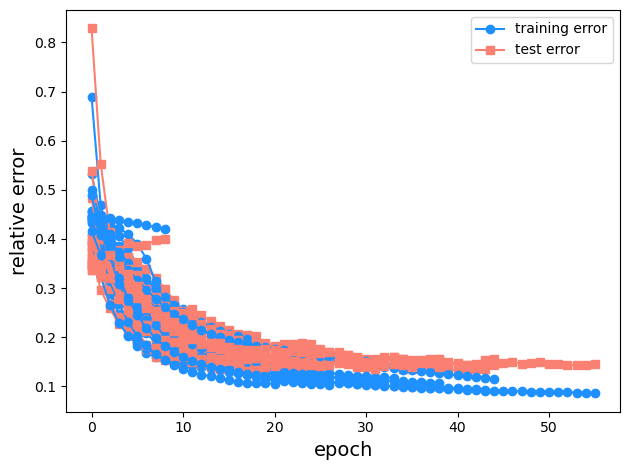

In [44]:
plot_errors(results_das)

### Get training results

In [45]:
# select the surrogate with the lowest test error
epoch_stop = results_das['epoch_stop']
test_errors = np.array(results_das['errors'])[:, :, 1]
test_errors = [error[epoch_stop[idx]] for idx, error in enumerate(test_errors)]
best_idx = np.argmin(test_errors)
das_surrogate = results_das['surrogate'][best_idx]
C_das = results_das['C_das'][best_idx]

# compute the active subspace on the training and test data
W_1 = results_das['projection_matrix'][best_idx]
y_das_train = np.dot(W_1.T, params_train.T).T
y_das_test = np.dot(W_1.T, params_test.T).T

### Recreate the eigenvalue plots

Plot the eigenvalues with confidence intervals. If the replica ensemble contains non-converged networks, this will show up as unreasonably large confidence intervals.

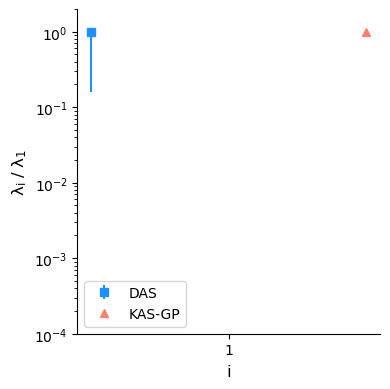

In [46]:
# number of eigenvalues to plot
n_vals = d

# basic analysisclass to compute the confidence intervals
analysis = es.analysis.BaseAnalysis()

# DAS eigenvalues
eigvals_C_das = results_das['eigvals'] 
eigvals_C_das = eigvals_C_das / np.mean(eigvals_C_das, axis=0)[0]
# eigenvalues averaged over the n_rep replica networks
mean_eigval_das = np.mean(eigvals_C_das[:, 0:n_vals], axis=0)
# compute confidence intervals
lower, upper = analysis.get_confidence_intervals(eigvals_C_das[:, 0:n_vals])
y_err_das = np.array([mean_eigval_das - lower, upper - mean_eigval_das])

# Load GP results from file
GP_eigvals = pd.read_csv('./GP_eigvals/scaled_eigen_results_epoxy_%s.csv' % (QoI,))
GP_mean = GP_eigvals['Eigenval_mean'].values
GP_std = GP_eigvals['Eigenval_std'].values

# plot results.
fig = plt.figure(figsize=[4, 4])
ax1 = fig.add_subplot(111, yscale='log', ylim=[1e-4, 2])
ax1.set_ylabel(r'$\lambda_i\;/\;\lambda_1$', fontsize=12)
ax1.set_xlabel(r'$i$', fontsize=12)
offset = 0.1
ax1.errorbar(np.arange(1, n_vals + 1)-offset, mean_eigval_das, 
             yerr = y_err_das, fmt='s', color='dodgerblue', label='DAS')
ax1.errorbar(np.arange(1, n_vals + 1)+offset, GP_mean[0:n_vals], 
             fmt='^', color='salmon', label='KAS-GP')#, yerr = GP_std[0:n_vals])
plt.legend(loc=0)
ax1.set_xticks(np.arange(1, n_vals + 1, 1))
sns.despine(top=True)
plt.tight_layout()

fig.savefig('./images/epoxy_eigvals_d%d.png' % (d,))

### Recreate the active subspace plot

Plot the predictions in a 1D active subspace.

In [47]:
# run the surrogate at a number of random inputs locations drawn from U[-1, 1]
n_mc = 1000
pred_inputs = np.random.rand(n_mc, D) * 2 - 1
das_samples_pred = np.zeros(n_mc)
for i in range(n_mc):
    das_samples_pred[i] = das_surrogate.predict(pred_inputs[i])

In [48]:
# active subspace at prediction inputs x
y_val_das = np.dot(W_1.T, pred_inputs.T).T
idx = np.argsort(y_val_das.flatten())

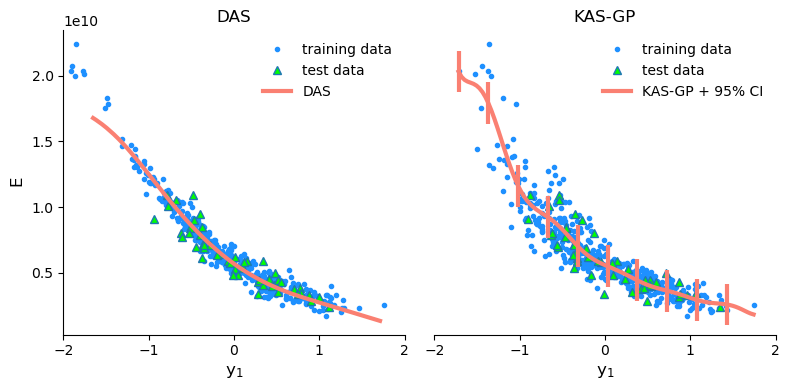

In [49]:
# QoI labels
lbl = {'E11': r'$E$', 'poisson': r'Poisson ratio'}

# plot DAS surrogate
fig = plt.figure(figsize=(8,4))
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, 1])

ax = fig.add_subplot(spec[0],  xlim=[-2,2], title='DAS')   
#ax = fig.add_subpl2ot(111, ylim = [0.15, 0.45], xlim= [-2, 2]) # Poisson range
ax.set_xlabel(r'$y_1$', fontsize=12)
ax.set_xticks([-2, -1, 0, 1, 2])
ax.set_ylabel(lbl[QoI], fontsize=12)
ax.plot(y_das_train[:,0], samples_train, '.', color='dodgerblue', label='training data') 
ax.plot(y_das_test[:,0], samples_test, '^', markerfacecolor='lime', label='test data') 
ax.plot(y_val_das[idx,0], das_samples_pred[idx], color='salmon', label='DAS', linewidth=3)
leg = ax.legend(loc=0, frameon=False)

ax2 = fig.add_subplot(spec[1], sharex = ax, ylim = ax.get_ylim(), title='KAS-GP') 
ax2.set_xlabel(r'$y_1$', fontsize=12)

# also plot GP surrogate from file
y_mean = das_surrogate.neural_net.y_mean
y_std = das_surrogate.neural_net.y_std
GP_surrogate = np.load('./GP_surrogate/epoxy_%s_results.npy' % (QoI,), allow_pickle=True).item()
ax2.plot(GP_surrogate['reduced_train_params'], samples_train, '.', color='dodgerblue', label='training data')
ax2.plot(GP_surrogate['reduced_test_params'], samples_test, '^', markerfacecolor='lime', label='test data')
ax2.plot(GP_surrogate['active_subspace'], GP_surrogate['prediction_mean'] * y_std + y_mean, color='salmon',
        label='KAS-GP + 95% CI', linewidth=3)
skip=10
ax2.errorbar(GP_surrogate['active_subspace'][0:-1:skip].flatten(), 
             GP_surrogate['prediction_mean'][0:-1:skip].flatten() * y_std + y_mean,
             yerr = GP_surrogate['prediction_CI'][0:-1:skip].flatten() * y_std, color='salmon',
             linewidth=0, elinewidth=3)
leg = ax2.legend(loc=0, frameon=False)

sns.despine(top=True, ax=ax)
sns.despine(top=True, ax=ax2)
sns.despine(left=True, ax=ax2)
ax2.set_yticks([])

plt.tight_layout()
plt.savefig('./images/epoxy_surrogate_d%d_%s.png' % (d, QoI, ))


### Recreate the global-derivative based sensitivity plots

In [50]:
GP_results = pd.read_csv('./GP_SA/sensitivity_indices_epoxy_%s.csv' % (QoI,))

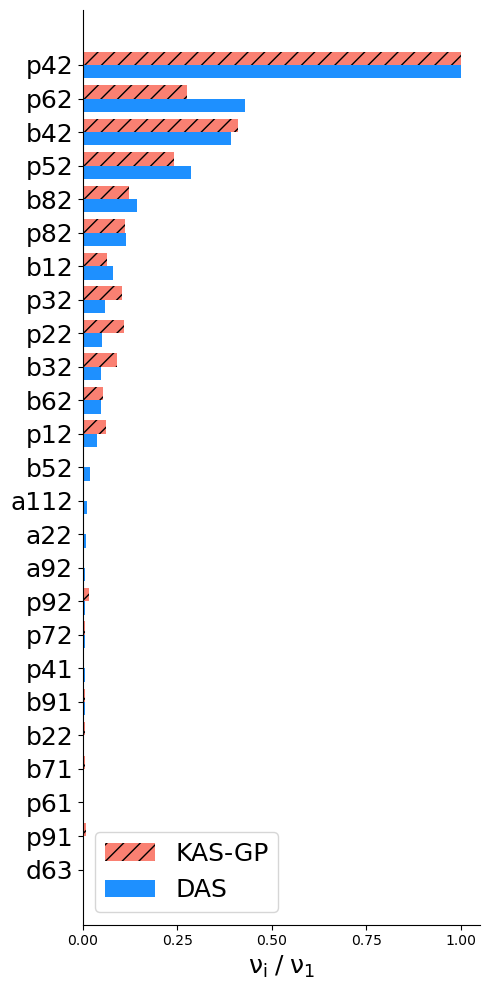

In [51]:
# plot sensitivity indices with CIs
plot_sensitivity(results_das, param_names, bar2 = GP_results)

### Compare epistemic with aleatoric uncertainty

Computing kernel-density estimate
done
Computing kernel-density estimate
done
Computing kernel-density estimate
done


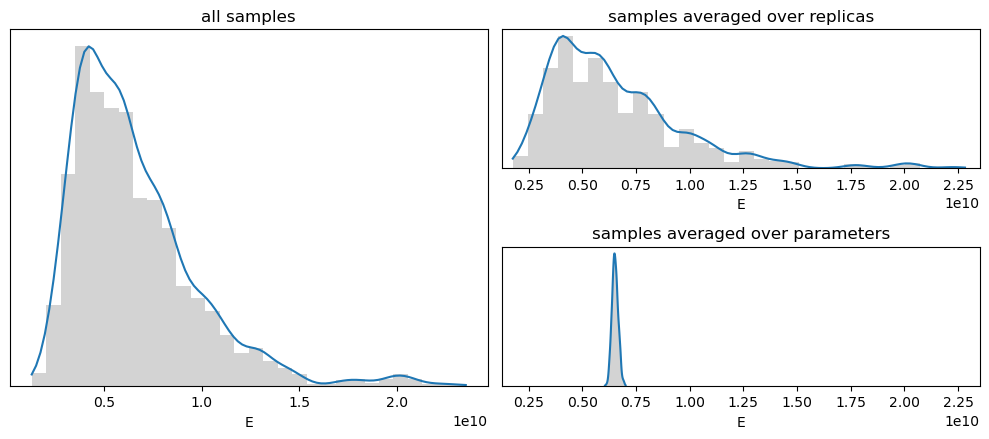

In [52]:
plot_dist(output, lbl[QoI])

### (Non-Gaussian) stats with bootstrapping

In [53]:
n_bootstap = 10 ** 5
n_samples = output.size

mean = np.zeros(n_bootstap)
std = np.zeros(n_bootstap)
skew = np.zeros(n_bootstap)
kurt = np.zeros(n_bootstap)

output = output.flatten() 

for i in tqdm(range(n_bootstap)):
    # resample with replacement
    idx = np.random.randint(0, n_samples, n_samples)
    # recompute moments
    mean[i] = np.mean(output[idx])
    std[i] = np.std(output[idx])
    skew[i] = stats.skew(output[idx])
    kurt[i] = stats.kurtosis(output[idx])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [02:57<00:00, 563.86it/s]


In [54]:
lower_mean, upper_mean = analysis.get_confidence_intervals(mean.reshape([-1,1]))
lower_std, upper_std = analysis.get_confidence_intervals(std.reshape([-1,1]))
lower_skew, upper_skew = analysis.get_confidence_intervals(skew.reshape([-1,1]))
lower_kurt, upper_kurt = analysis.get_confidence_intervals(kurt.reshape([-1,1]))

In [55]:
print("Mean: %.2e (%.2e/%.2e)" % (np.mean(output), lower_mean, upper_mean))
print("Std dev: %.2e (%.2e/%.2e)" % (np.std(output), lower_std, upper_std))
print("Skew: %.2f (%.3f/%.3f)" % (stats.skew(output), lower_skew, upper_skew))
print("Kurt: %.2f (%.2f/%.2f)" % (stats.kurtosis(output), lower_kurt, upper_kurt))
print("N_samples = %d" % n_samples)

Mean: 6.54e+09 (6.49e+09/6.59e+09)
Std dev: 3.22e+09 (3.16e+09/3.28e+09)
Skew: 1.61 (1.541/1.666)
Kurt: 3.76 (3.45/4.05)
N_samples = 10000
